In [118]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from collections import Counter
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

device = torch.device("cpu")


In [119]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [120]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s, is_cn=False):
    if (is_cn):
        s = s.strip()
        s = re.sub(r"([。！？])", r" \1", s)
    else:
        s = unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [121]:
# def cn_tokenizer(sentence):
#     return [normalizeString(word, True) for word in list(sentence)]

cn_tokenizer = get_tokenizer('spacy', language='zh_core_web_sm')
en_tokenizer_ = get_tokenizer('spacy', language='en_core_web_sm')

def en_tokenizer(sentence):
    return en_tokenizer_(sentence)

In [122]:
def build_vocab():
    counter1 = Counter()
    counter2 = Counter()
    # Read the file and split into lines
    lines = open('data/en-cn.txt', encoding='utf-8').read().strip().split('\n')
    for l in lines:
        l1, l2 = l.split('\t')
        counter1.update(en_tokenizer(l1))
        counter2.update(cn_tokenizer(l2))

    vocab1 = vocab(counter1, specials=['<unk>', '<pad>', '<sos>', '<eos>'])
    vocab2 = vocab(counter2, specials=['<unk>', '<pad>', '<sos>', '<eos>'])
    vocab1.set_default_index(vocab1["<unk>"])
    vocab2.set_default_index(vocab2["<unk>"])
    return [vocab1, vocab2]


en_vocab, cn_vocab = build_vocab()


In [123]:
cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)
print('cn vocab size', cn_vocab_size)
print('en vocab size', en_vocab_size)

cn vocab size 11280
en vocab size 7910


In [124]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filter_sentence(l1, l2, max_length):
    l1_words = en_tokenizer(l1)
    l2_words = cn_tokenizer(l2)
    return len(l1_words) < max_length and len(l2_words) < max_length and normalizeString(l1, False).startswith(eng_prefixes)


class TranslationDataset(Dataset):
    def __init__(self, max_length):
        self.data = []
        self.pairs = []
        self.max_length = max_length
        lines = open('data/en-cn.txt',
                     encoding='utf-8').read().strip().split('\n')
        for l in lines:
            l1, l2 = l.split('\t')
            if (filter_sentence(l1, l2, max_length)):
                cn_tensor_ = self.tokenize_sentence(l2, True)
                en_tensor_ = self.tokenize_sentence(l1, False)
                self.data.append((cn_tensor_, en_tensor_))
                self.pairs.append((l2, l1))

        self.len = len(self.data)

    def tokenize_sentence(self, sentence, is_cn):
        vocab = cn_vocab if is_cn else en_vocab
        tokenizer = cn_tokenizer if is_cn else en_tokenizer
        indexes = [vocab[token] for token in tokenizer(sentence)]
        indexes = [vocab['<sos>']] + indexes + [vocab['<eos>']]
        return torch.tensor(indexes, dtype=torch.long)

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.len


In [125]:
seq_len = 50
batch_size = 1

In [126]:
def collate_fn(batch):
    source = [item[0] for item in batch] 
    #pad them using pad_sequence method from pytorch. 
    source = pad_sequence(source, batch_first=True, padding_value=cn_vocab['<pad>']) 
    
    #get all target indexed sentences of the batch
    target = [item[1] for item in batch] 
    #pad them using pad_sequence method from pytorch. 
    target = pad_sequence(target, batch_first=True, padding_value=en_vocab['<pad>'])
    return source, target

train_dataset = TranslationDataset(seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [127]:
def to_sentence(indexes, is_cn):
    vacab = cn_vocab if (is_cn) else en_vocab
    return[vacab.get_itos()[index] for index in indexes]

In [128]:
for i, item in enumerate(train_loader):
    print(item[0].shape, item[1].shape)
    print(to_sentence(item[0][0], True))
    print(to_sentence(item[1][0], False))
    break

torch.Size([1, 9]) torch.Size([1, 11])
['<sos>', '我', '待', '在', '东京', '的', '舅舅家', '。', '<eos>']
['<sos>', 'I', 'am', 'staying', 'with', 'my', 'uncle', 'in', 'Tokyo', '.', '<eos>']


In [129]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        batch_size = input.size(0)
        hidden = torch.zeros(1, batch_size, self.hidden_size, device=device)
        embedded = self.dropout(self.embedding(input))
        outputs, hidden = self.gru(embedded, hidden)

        return outputs, hidden


In [130]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        hidden = hidden.permute(1, 0, 2)
        # repeat decoder hidden state src_len times, hidden = [batch size, seq len, hidden size]
        hidden = hidden.repeat(1, seq_len, 1)

        # [batch size, seq len, hidden size * 2]
        outputs_cat_hidden = torch.cat((hidden, encoder_outputs), dim=2)

        # energy = [batch size, src len, hidden size]
        energy = torch.tanh(self.attn(outputs_cat_hidden))

        # attention= [batch size, src len]
        attention = self.v(energy).squeeze(2)

        return self.softmax(attention)


In [131]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.attention = Attention(hidden_size)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.GRU(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size * 3, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size, 1]
        # hidden = [1, batch size, hidden_size]
        # encoder_outputs = [batch size, src len, hidden_size]

        # embedded = [batch size, hidden_size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, hidden_size]
        embedded = embedded.unsqueeze(0)

        # a = [batch size, src len]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, 1, src len]
        a = a.unsqueeze(1)

        # weighted = [batch size, 1, hidden_size]
        weighted = torch.bmm(a, encoder_outputs)

        # weighted = [1, batch size, hidden_size]
        weighted = weighted.permute(1, 0, 2)

        # rnn_input = [1, batch size, hidden_size * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)

        # output = [seq len, batch size, hidden_size]
        # hidden = [n_layers, batch size, hidden_size]
        output, hidden = self.rnn(rnn_input, hidden)

        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, dec hid dim]
        # hidden = [1, batch size, dec hid dim]
        # this also means that output == hidden
        # assert (output == hidden).all()

        # embedded = [batch size, hidden_size]
        embedded = embedded.squeeze(0)
        # output = [batch size, hidden_size]
        output = output.squeeze(0)
        # weighted = [batch size, hidden_size]
        weighted = weighted.squeeze(0)

        # prediction = [batch size, output size]
        prediction = self.out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden, a


In [132]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    target_tensor = target_tensor[:, 1:]
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(1)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor)

    decoder_input = input_tensor[:, 0]

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            target = target_tensor[:, di]
            loss += criterion(decoder_output, target)
            decoder_input = target  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()  # detach from history as input

            target = target_tensor[:, di]
            loss += criterion(decoder_output, target)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [133]:
def trainIters(encoder, decoder, train_loader, print_every=100, plot_every=10, learning_rate=0.0005):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(ignore_index=cn_vocab['<pad>'])
    n_iters = len(train_loader)

    for iter, data in enumerate(train_loader, 1):
        input_tensor, target_tensor = data

        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [134]:
hidden_size = 256
encoder1 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder1 = Decoder(hidden_size, en_vocab_size).to(device)

In [135]:
train_losses = []
for i in range(3):
    print('--------------epoch %d--------------' % (i + 1))
    losses = trainIters(encoder1, decoder1, train_loader, print_every=200)
    train_losses = train_losses + losses

--------------epoch 1--------------
0m 14s (- 2m 31s) (200 8%) 7.7914
0m 28s (- 2m 13s) (400 17%) 6.1273
0m 42s (- 2m 0s) (600 26%) 5.5832
0m 57s (- 1m 46s) (800 34%) 5.3001
1m 10s (- 1m 31s) (1000 43%) 4.9732
1m 25s (- 1m 17s) (1200 52%) 4.8681
1m 39s (- 1m 3s) (1400 61%) 4.6214
1m 53s (- 0m 49s) (1600 69%) 4.6112
2m 7s (- 0m 35s) (1800 78%) 4.4447
2m 22s (- 0m 20s) (2000 87%) 4.3750
2m 36s (- 0m 6s) (2200 95%) 4.2828
--------------epoch 2--------------
0m 13s (- 2m 25s) (200 8%) 4.0595
0m 28s (- 2m 13s) (400 17%) 4.1333
0m 42s (- 2m 0s) (600 26%) 4.0923
0m 56s (- 1m 45s) (800 34%) 4.0069
1m 10s (- 1m 31s) (1000 43%) 3.9404
1m 24s (- 1m 17s) (1200 52%) 3.9615
1m 39s (- 1m 3s) (1400 61%) 3.9872
1m 53s (- 0m 49s) (1600 69%) 3.9280
2m 7s (- 0m 34s) (1800 78%) 3.8610
2m 21s (- 0m 20s) (2000 87%) 3.9137
2m 35s (- 0m 6s) (2200 95%) 3.8313
--------------epoch 3--------------
0m 14s (- 2m 29s) (200 8%) 3.7053
0m 29s (- 2m 18s) (400 17%) 3.8716
0m 44s (- 2m 4s) (600 26%) 3.7376
0m 58s (- 1m 48

<Figure size 640x480 with 0 Axes>

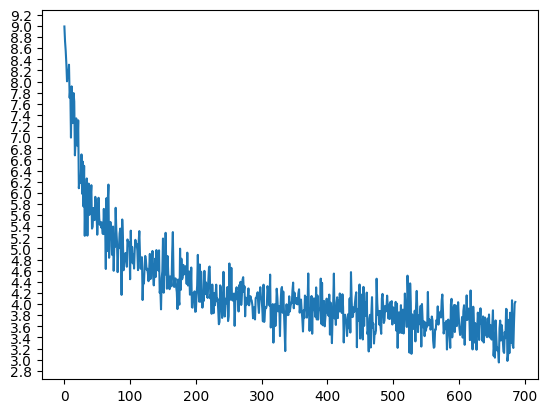

In [136]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [137]:
encoder_path = './models/seq2seq6-encoder.pt'
decoder_path = './models/seq2seq6-decoder.pt'


In [138]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)


In [139]:
def evaluate(encoder, decoder, sentence, max_length=seq_len):
    with torch.no_grad():
        input_tensor = train_dataset.tokenize_sentence(sentence, True).unsqueeze(0)
        input_length = input_tensor.size(1)

        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor([cn_vocab['<sos>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            decoder_attentions[di] = decoder_attention.squeeze().data
            if topi.item() == en_vocab['<eos>']:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_vocab.lookup_token(topi.item()))

            decoder_input = topi.squeeze(1).detach()

        return decoded_words, decoder_attentions[:di + 1]


In [140]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [141]:
encoder2 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder2 = Decoder(hidden_size, en_vocab_size).to(device)

encoder2.load_state_dict(torch.load(encoder_path))
decoder2.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

In [142]:
evaluateRandomly(encoder2, decoder2)


> 我现在不特别渴。
= I'm not particularly thirsty right now.
< I 'm not . . <EOS>

> 他是个网球球手。
= He's a tennis player.
< He is a to . . <EOS>

> 她擅于逃避规则。
= She's good at getting around rules.
< He 's a good at . <EOS>

> 我完全同意。
= I'm in absolutely total agreement.
< I 'm not to . . <EOS>

> 她现在忙，不能跟你说话。
= She's busy now and can't talk with you.
< You 're the one who . <EOS>

> 我将主修法文。
= I am going to major in French.
< I 'm not to . . <EOS>

> 你仍然很年轻。
= You're still young.
< He 's not to . <EOS>

> 我是世界公民。
= I'm a citizen of the world.
< I 'm not to . . . <EOS>

> 他非常亲切。
= He is very kind.
< He is a to . . . <EOS>

> 我们很高兴你加入了我们班。
= We are glad to have you in our class.
< You 're the same . <EOS>



I 'm not to . . <EOS>


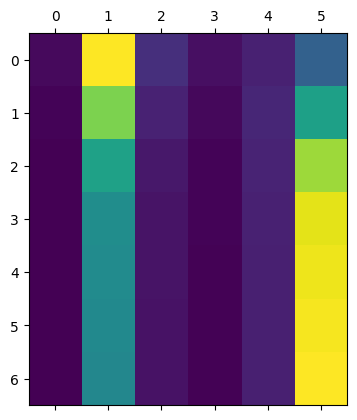

In [143]:
output_words, attentions = evaluate(encoder2, decoder2, "我不确定。")
output_sentence = ' '.join(output_words)
print(output_sentence)
plt.matshow(attentions.numpy())


In [144]:
# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + list(input_sentence) +
#                        ['<EOS>'], rotation=90)
#     ax.set_yticklabels([''] + output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()


# def evaluateAndShowAttention(input_sentence):
#     output_words, attentions = evaluate(encoder2, decoder2, input_sentence)
#     print('input =', input_sentence)
#     print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("我不确定。")


In [145]:
cn_vocab.get_stoi()['.']

286